# TOC

1. **Preparation**
    1. Import Libraries
    1. Classes
    1. Constances
    1. Load Data
2. **Model**
    1. Functions
        1. Classification
        1. Plots
    1. Gradient Descent Algorithm
3. **Execution**
    1. Train model
        1. normal data 
        2. numerical data
    1. Plot Bivariate Gaussian
        1. normal data 
        2. numerical data
4. **Conclusion**
    1. Datasets
    2. Approach
    3. Results: normal data
    4. Results: numerical data


# Preparation

### Preparation > Import libraries

In [1]:
''' IMPORTS '''
import numpy as np
import pandas as pd
import matplotlib as plot
import math 
import string

from enum import Enum    

# for plotting
import matplotlib.pyplot as plt
import scipy.stats as stats

from matplotlib import cm
from scipy.stats import multivariate_normal

### Preparation > Classes

In [2]:
'''CLASSES '''


# columns of german.data (normal)
class Cols(Enum):
        StatusOfExistingCheckingAccount = 0,
        DurationInMonth = 1, 
        CreditHistory = 2, 
        Purpose = 3, 
        CreditAmount = 4 , 
        SavingsAccountBonds =5,
        PresentEmploymentSince =6 ,
        InstallmentRateInPercentageOfDisposableIncome =7 ,
        PersonalStatusAndSex = 8,
        OtherDebtorsOrGuarantors =9 ,
        PresentResidenceSince =10 ,
        Property =11 ,
        AgeInYears = 12,
        OtherInstallmentPlans =13 ,
        Housing = 14,
        NumberOfExistingCreditsAtThisBank =15 ,
        Job = 16,
        NumberOfPeopleBeingLiableToProvideMaintenanceFor =17 ,
        Telephone = 18,
        ForeignWorker =19 ,
        ClassOutcome = 20
        

# Classes (Good, Bad) as values
class Outcomes(Enum):
        Good = 1
        Bad = 2

### Preparation > Constances

In [3]:
'''CONSTANCES'''



# dict of all column names for german.data (normal)
COLS = {
        Cols.StatusOfExistingCheckingAccount : "Status of existing checking account" ,
        Cols.DurationInMonth:"Duration in month" , # numerical
        Cols.CreditHistory: "Credit history", 
        Cols.Purpose:"Purpose" , 
        Cols.CreditAmount:  "Credit amount",  # numerical
        
        Cols.SavingsAccountBonds: "Savings account/bonds" ,
        Cols.PresentEmploymentSince:"Present employment since" ,
        Cols.InstallmentRateInPercentageOfDisposableIncome: "Installment rate in percentage of disposable income", # numerical
        Cols.PersonalStatusAndSex: "Personal status and sex",
        Cols.OtherDebtorsOrGuarantors:"Other debtors / guarantors", 
        
        Cols.PresentResidenceSince: "Present residence since", # numerical
        Cols.Property: "Property", 
        Cols.AgeInYears: "Age in years", # numerical
        Cols.OtherInstallmentPlans:"Other installment plans", 
        Cols.Housing: "Housing", 
        
        Cols.NumberOfExistingCreditsAtThisBank:"Number of existing credits at this bank", # numerical
        Cols.Job: "Job",
        Cols.NumberOfPeopleBeingLiableToProvideMaintenanceFor:"Number of people being liable to provide maintenance for", 
        Cols.Telephone: "Telephone",
        Cols.ForeignWorker:"Foreign worker",
        
        Cols.ClassOutcome: "Class/Outcome"
}

# numerical attributes of german.data
numerical_attr = [
    COLS[Cols.DurationInMonth],
    COLS[Cols.CreditAmount],
    COLS[Cols.PresentResidenceSince],
    COLS[Cols.InstallmentRateInPercentageOfDisposableIncome], 
    COLS[Cols.AgeInYears], 
    COLS[Cols.NumberOfExistingCreditsAtThisBank],
]

# model parameter
PERC_TRAIN = 0.67
PERC_TEST = 1-PERC_TRAIN
RISK_MATRIX = np.array([
    [0,1],
    [5,0]
])

# constants
PI = np.pi

### Model > Load Data

In [4]:
df_normal = pd.read_csv(
    "german.data", 
    sep=" ",
    names=[
        COLS[Cols.StatusOfExistingCheckingAccount],
        COLS[Cols.DurationInMonth],
        COLS[Cols.CreditHistory],
        COLS[Cols.Purpose],
        COLS[Cols.CreditAmount],
        COLS[Cols.SavingsAccountBonds],
        COLS[Cols.PresentEmploymentSince],
        COLS[Cols.InstallmentRateInPercentageOfDisposableIncome],
        COLS[Cols.PersonalStatusAndSex],
        COLS[Cols.OtherDebtorsOrGuarantors],
        COLS[Cols.PresentResidenceSince],
        COLS[Cols.Property],
        COLS[Cols.AgeInYears],
        COLS[Cols.OtherInstallmentPlans],
        COLS[Cols.Housing],
        COLS[Cols.NumberOfExistingCreditsAtThisBank],
        COLS[Cols.Job],
        COLS[Cols.NumberOfPeopleBeingLiableToProvideMaintenanceFor],
        COLS[Cols.Telephone],
        COLS[Cols.ForeignWorker],
        COLS[Cols.ClassOutcome],
    ])


df_numerical = pd.read_csv(
    "german.data-numeric", 
    delim_whitespace=True,
    header=None,
    names = [
        'a','b','c','d','e',
        'f','g','h','i','j',
        'k','l','m','n','o',
        'p','q','r','s','t',
        'u','v','w','x', COLS[Cols.ClassOutcome]]
)

df_normal.head(3)

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,Foreign worker,Class/Outcome
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


# Model

### Model > Functions > Classification

In [5]:
'''FUNCTIONS'''
    
# to calculate un-normalized posteriors and do classification with respect to g1 and g2results
def do_classification(df_test, cols,
                      prior_good, muv_good, covma_good,
                      prior_bad, muv_bad, covma_bad):
    decision_list = []  # to store classification results (+ risk) to calculate accuracy later.
    
    # classify all test rows
    for index, row in df_test.iterrows():
        pred_good = discriminant_func(x=row, cols=cols, prior=prior_good, mus=muv_good, covma=covma_good)
        pred_bad = discriminant_func(x=row, cols=cols, prior=prior_bad, mus=muv_bad, covma=covma_bad)
        
        classified_class = Outcomes.Good.value
        
        # calculate risk for each class
        risk_good = pred_bad  * RISK_MATRIX[0,1] # actual class = GOOD(0), predicted class = BAD(1)
        risk_bad  = pred_good * RISK_MATRIX[1,0] # actual class = BAD(1) , predicted class = GOOD(2)

        # classify class by taking higher posterior (-> higher probabilty)
        classified_class = [Outcomes.Good.value,risk_good] if pred_good>pred_bad else [Outcomes.Bad.value,risk_bad]
            
        decision_list.append(classified_class)
        
    return np.array(decision_list)


def discriminant_func(x, cols, prior, mus, covma):
    cov01 = covma[0,1]
    standard_dev = math.sqrt(abs(cov01))
    
    if standard_dev == 0:
        return -900000000
    
    res =  (
            -(math.log(2*PI)/2) 
            - math.log(standard_dev) 
            - ((x[cols[0]]-mus[0])**2)/(2*cov01) 
            + np.log(prior)
        )+ (
            -(math.log(2*PI)/2) 
            - math.log(standard_dev) 
            - ((x[cols[1]]-mus[1])**2)/(2*cov01) 
            + np.log(prior)
    )
    return res

### Model > Functions > Plot

In [6]:
def plot_contour(mu_good, covma_good, mu_bad, covma_bad, scale, top_attr):
    '''
    plots a contour plot for given gaussian attributes (mu, covmatrix)
    '''    
    mu0_big = max(mu_good[0], mu_bad[0])
    mu1_big = max(mu_good[1], mu_bad[1])
    
    x = np.linspace(0, mu0_big*scale, num=100)
    y = np.linspace(0, mu1_big*scale, num=100)
    X, Y = np.meshgrid(x,y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    Z_good = multivariate_normal(mu_good, covma_good).pdf(pos)
    Z_bad = multivariate_normal(mu_bad, covma_bad).pdf(pos)
    Z = (Z_bad - Z_good)
    
    # plot
    plt.figure(2)
    plt.title(f'''2D-Gauss distributions for Class 1 & 2''')
    plt.xlabel(f"{top_attr[0]}")
    plt.ylabel(f"{top_attr[1]}")

    CS=plt.contour(X, Y, Z,)
    plt.clabel(CS, inline=1, fontsize=10)
    
    plt.annotate('Good',(60,10))
    plt.annotate('Bad',(60,40))
    
    plt.figtext(
        0, 
        -0.25, 
        f'''[GOOD] $\mu$={mu_good}, $\sigma$={round(covma_good[0,1],2)}\n[BAD]  $\mu$={mu_bad}, $\sigma$={round(covma_bad[0,1],2)}
        ''',fontsize = 15)
    
    
    plt.show()

        
def plot_sample(df, top_attr, plot_scale):
    '''
    - seperates {df} in class good & bad 
    - calculates gaussian variables (mu & covmatrix) for each class
    - plots 2d gaussiann for each class
    '''
    # plot distribution for best attributes
    df_plot = pd.DataFrame({
        top_attr[0]: df[top_attr[0]],
        top_attr[1]: df[top_attr[1]],
        COLS[Cols.ClassOutcome]: df[COLS[Cols.ClassOutcome]]
    })

    # class GOOD - mu & covma
    df_plot_good = df_plot.loc[df_plot[COLS[Cols.ClassOutcome]] == Outcomes.Good.value]
    df_plot_good_cov = pd.DataFrame({
        top_attr[0]: df_plot_good[top_attr[0]],
        top_attr[1]: df_plot_good[top_attr[1]]
    })
    mu_good = [df_plot_good[top_attr[0]].mean(), df_plot_good[top_attr[1]].mean()]
    mu_good = list(map(lambda x: round(x, 2), mu_good))
    
    
    covma_good = df_plot_good_cov.cov().to_numpy()
    
    # class BAD - mu & covma
    df_plot_bad  = df_plot.loc[df_plot[COLS[Cols.ClassOutcome]] == Outcomes.Bad.value]
    df_plot_bad_cov = pd.DataFrame({
        top_attr[0]: df_plot_bad[top_attr[0]],
        top_attr[1]: df_plot_bad[top_attr[1]],
    })
    mu_bad =  [df_plot_bad [top_attr[0]].mean(), df_plot_bad [top_attr[1]].mean()]
    mu_bad = list(map(lambda x: round(x, 2), mu_bad))

    covma_bad = df_plot_bad_cov.cov().to_numpy()
    
    # plot good & bad
    plot_contour(
        mu_good=mu_good, covma_good=covma_good,
        mu_bad=mu_bad, covma_bad=covma_bad,
        scale=plot_scale, top_attr=top_attr
    )

## Model > Gradient Descent Algorithm

In [7]:
def routine_gradient_descent(df, columns, iterations):
    '''
    - determines top 2 attributes of {columns} which provide highest accuracy for given dataset {df}
    - for each attribut combination the gradient descent algorithm is called with n={iterations}
   '''
    max_avg_acc = 0
    top_attr = []
    
    # iterate through all possible attributes to determine highest accuracy
    for i, attr1 in enumerate(columns):
        for attr2 in columns:
            if attr1 == attr2:
                continue

            df_focus = pd.DataFrame({
                        attr1 : df[attr1],
                        attr2 : df[attr2],
                        COLS[Cols.ClassOutcome] : df[COLS[Cols.ClassOutcome]]
            })
            max_avg, _, _, _, _ = gradient_descent(df_focus, iterations)

            if max_avg > max_avg_acc:
                max_avg_acc = max_avg
                top_attr = [attr1,attr2]
                
        print(f"=============Progress: {round((i+1)/len(columns),2)}==============")

    # print attributes that gives best parameter (mu, cov) for the model
    print(f'Best Avg. Acc: {max_avg_acc} with features: <{top_attr[0]}> & <{top_attr[1]}>')
    

def gradient_descent(df, iterations):
    '''
    - calculates gauss paramater of df in n={iterations} interations
    - splits data in 67% training data and 33% test data
    '''
    accuracy = 0  # total accuracy
    risk =     0  # total risk
    
    cols = df.columns

    accuracies=[] # to store individual accuracies
    risks=[]      # to store risks

    # program will run for 500 times to find average accuracy
    for i in range(0, iterations):    
        # split data train & test
        msk = np.random.rand(len(df)) < PERC_TRAIN
        df_train = df[msk]
        df_test = df[~msk]
        
        # separate in class 1 & 2
        df_good = df_train.loc[df_train[COLS[Cols.ClassOutcome]] == 1]    
        df_bad  = df_train.loc[df_train[COLS[Cols.ClassOutcome]] == 2]

        prior_good = len(df_good)/(len(df_good)+len(df_bad)) 
        prior_bad = len(df_bad)/(len(df_good)+len(df_bad)) 

        # calculate MUs and COVs(MLE parameters) of each class
        df_good_covma = pd.DataFrame({
            cols[0]: df_good[cols[0]],
            cols[1]: df_good[cols[1]],
        })
        muv_good = [df_good[cols[0]].mean(), df_good[cols[1]].mean()]
        covma_good = df_good_covma.cov().to_numpy()

        df_bad_covma = pd.DataFrame({
            cols[0]: df_bad[cols[0]],
            cols[1]: df_bad[cols[1]],
        })
        muv_bad = [df_bad[cols[0]].mean(), df_bad[cols[1]].mean()]
        covma_bad = df_bad_covma.cov().to_numpy()

        # classification_result is an array that stores the result of classification
        classification_result = do_classification(
            df_test=df_test, cols=cols,
            prior_good=prior_good, muv_good=muv_good, covma_good=covma_good, 
            prior_bad=prior_bad, muv_bad=muv_bad, covma_bad=covma_bad)

        # compare classification results with y_test 
        col1_acc = "classification"
        col2_acc = "df_test_y"
        col3_acc = "risk"
        df_classified = pd.DataFrame({
            col1_acc : classification_result[:,0],
            col2_acc : df_test[COLS[Cols.ClassOutcome]],
            col3_acc : classification_result[:,1],

        })
        
        # calculate accuracy (devide #correctClassifiedRows by #allRows)
        df_acc = df_classified.loc[(df_classified[col1_acc] == df_classified[col2_acc])] 
        individual_accuracy = df_acc.shape[0]/df_test.shape[0]    
        accuracy = accuracy + individual_accuracy
        accuracies.append(individual_accuracy)
        
        # calculate risk
        individual_avg_risk = df_classified[col3_acc].mean()
        risk = risk + individual_avg_risk
        risks.append(individual_avg_risk)
        

    # print results + update best avg. accuracy
    print(f"<{cols[0]}> x <{cols[1]}>")
    acc_avg  = round((accuracy/iterations)*100,2)
    risk_avg = round((risk/iterations)*100,2)
    print(f"Avg Acc. = {acc_avg}%, Max Acc. = {round(max(accuracies)*100,2)}%\nAvg Risk = {risk_avg}, Max Risk = {round(max(risks)*100,2)}\n")
    return acc_avg, muv_good, covma_good, muv_bad, covma_bad

# Execution

## Execution > Train model 

## Execution > Train model > normal data (7 numerical attributes / 7*7 combinations)

In [8]:
max_avg = routine_gradient_descent(
    df=df_normal, 
    columns=numerical_attr, 
    iterations=500
)

<Duration in month> x <Credit amount>
Avg Acc. = 61.6%, Max Acc. = 68.73%
Avg Risk = -104450.35, Max Risk = -48979.03

<Duration in month> x <Present residence since>
Avg Acc. = 52.94%, Max Acc. = 74.77%
Avg Risk = -297336.17, Max Risk = -3103.87

<Duration in month> x <Installment rate in percentage of disposable income>
Avg Acc. = 52.75%, Max Acc. = 73.9%
Avg Risk = -71662.65, Max Risk = -11112.9

<Duration in month> x <Age in years>
Avg Acc. = 65.46%, Max Acc. = 75.91%
Avg Risk = -12032.9, Max Risk = 23328.14

<Duration in month> x <Number of existing credits at this bank>
Avg Acc. = 61.13%, Max Acc. = 75.96%
Avg Risk = -382459.25, Max Risk = 943070.06

=============Progress: 0.17==============
<Credit amount> x <Duration in month>
Avg Acc. = 61.59%, Max Acc. = 67.71%
Avg Risk = -103467.79, Max Risk = -55572.41

<Credit amount> x <Present residence since>
Avg Acc. = 51.19%, Max Acc. = 74.85%
Avg Risk = -95475194.48, Max Risk = 71075303.53

<Credit amount> x <Installment rate in perc

### Execution > Train model > numerical data (24 numerical attributes / 24*24 combinations)

In [9]:
max_avg = routine_gradient_descent(df_numerical, df_numerical.columns, 100)

<a> x <b>
Avg Acc. = 35.6%, Max Acc. = 69.88%
Avg Risk = -142677.9, Max Risk = 282548.39

<a> x <c>
Avg Acc. = 67.64%, Max Acc. = 75.14%
Avg Risk = -4453.67, Max Risk = -2613.31

<a> x <d>
Avg Acc. = 60.89%, Max Acc. = 75.46%
Avg Risk = -288018.23, Max Risk = 311380.33

<a> x <e>
Avg Acc. = 68.28%, Max Acc. = 73.64%
Avg Risk = -2546.7, Max Risk = -1826.61

<a> x <f>
Avg Acc. = 31.87%, Max Acc. = 71.39%
Avg Risk = -10260.89, Max Risk = -3317.12

<a> x <g>
Avg Acc. = 45.4%, Max Acc. = 73.94%
Avg Risk = -29668.63, Max Risk = 86502.45

<a> x <h>
Avg Acc. = 51.52%, Max Acc. = 74.39%
Avg Risk = -77588.61, Max Risk = 8684.25

<a> x <i>
Avg Acc. = 33.0%, Max Acc. = 73.07%
Avg Risk = -14586.67, Max Risk = 3413.47

<a> x <j>
Avg Acc. = 41.71%, Max Acc. = 73.8%
Avg Risk = -131259.79, Max Risk = 31512.0

<a> x <k>
Avg Acc. = 29.76%, Max Acc. = 35.24%
Avg Risk = -10358.48, Max Risk = -4604.99

<a> x <l>
Avg Acc. = 56.37%, Max Acc. = 73.27%
Avg Risk = -25164.72, Max Risk = -1215.67

<a> x <m>
Avg Ac

<d> x <s>
Avg Acc. = 52.45%, Max Acc. = 72.0%
Avg Risk = -2036071.51, Max Risk = 1620802.43

<d> x <t>
Avg Acc. = 52.44%, Max Acc. = 74.1%
Avg Risk = -220748.75, Max Risk = 1652291.01

<d> x <u>
Avg Acc. = 40.63%, Max Acc. = 64.6%
Avg Risk = 71281.85, Max Risk = 219666.36

<d> x <v>
Avg Acc. = 54.99%, Max Acc. = 73.23%
Avg Risk = -2304211.07, Max Risk = 7862941.24

<d> x <w>
Avg Acc. = 47.3%, Max Acc. = 65.72%
Avg Risk = 23333.66, Max Risk = 44943.63

<d> x <x>
Avg Acc. = 45.03%, Max Acc. = 67.08%
Avg Risk = 52235.95, Max Risk = 1385574.76

<d> x <Class/Outcome>
Avg Acc. = 30.12%, Max Acc. = 35.38%
Avg Risk = -450000000000.0, Max Risk = -450000000000.0

=============Progress: 0.16==============
<e> x <a>
Avg Acc. = 69.0%, Max Acc. = 72.73%
Avg Risk = -2489.98, Max Risk = -1950.67

<e> x <b>
Avg Acc. = 31.26%, Max Acc. = 65.34%
Avg Risk = -16233.79, Max Risk = -9398.04

<e> x <c>
Avg Acc. = 55.61%, Max Acc. = 74.28%
Avg Risk = -52984.87, Max Risk = 64716.92

<e> x <d>
Avg Acc. = 57.46%,

<h> x <l>
Avg Acc. = 42.17%, Max Acc. = 72.33%
Avg Risk = -8343.52, Max Risk = -1109.64

<h> x <m>
Avg Acc. = 43.83%, Max Acc. = 73.75%
Avg Risk = -40625.16, Max Risk = -1019.35

<h> x <n>
Avg Acc. = 53.38%, Max Acc. = 76.0%
Avg Risk = -5460.93, Max Risk = -1588.05

<h> x <o>
Avg Acc. = 43.87%, Max Acc. = 74.19%
Avg Risk = -1799991119.98, Max Risk = 87086.49

<h> x <p>
Avg Acc. = 37.51%, Max Acc. = 72.16%
Avg Risk = -24812.51, Max Risk = 2182.57

<h> x <q>
Avg Acc. = 50.11%, Max Acc. = 72.97%
Avg Risk = -8640.24, Max Risk = -1496.54

<h> x <r>
Avg Acc. = 47.27%, Max Acc. = 74.78%
Avg Risk = -34282.21, Max Risk = 12308.86

<h> x <s>
Avg Acc. = 52.37%, Max Acc. = 74.77%
Avg Risk = -95263.68, Max Risk = 414037.22

<h> x <t>
Avg Acc. = 46.81%, Max Acc. = 70.81%
Avg Risk = -4677.64, Max Risk = -1044.43

<h> x <u>
Avg Acc. = 69.87%, Max Acc. = 75.22%
Avg Risk = 72.26, Max Risk = 218.67

<h> x <v>
Avg Acc. = 49.8%, Max Acc. = 74.21%
Avg Risk = -111809.52, Max Risk = 238326.65

<h> x <w>
Avg A

<l> x <c>
Avg Acc. = 69.25%, Max Acc. = 75.54%
Avg Risk = -927.26, Max Risk = -656.81

<l> x <d>
Avg Acc. = 53.8%, Max Acc. = 73.21%
Avg Risk = -780981.68, Max Risk = 560997.29

<l> x <e>
Avg Acc. = 53.01%, Max Acc. = 74.69%
Avg Risk = -20568.33, Max Risk = 159137.96

<l> x <f>
Avg Acc. = 66.84%, Max Acc. = 74.52%
Avg Risk = -3400.33, Max Risk = -1147.87

<l> x <g>
Avg Acc. = 57.58%, Max Acc. = 74.31%
Avg Risk = -8311.56, Max Risk = -1305.8

<l> x <h>
Avg Acc. = 45.05%, Max Acc. = 73.9%
Avg Risk = -9934.12, Max Risk = -917.4

<l> x <i>
Avg Acc. = 56.24%, Max Acc. = 74.13%
Avg Risk = -34664.07, Max Risk = 47760.66

<l> x <j>
Avg Acc. = 60.56%, Max Acc. = 71.26%
Avg Risk = -19485.72, Max Risk = -8270.82

<l> x <k>
Avg Acc. = 61.32%, Max Acc. = 73.59%
Avg Risk = -28497.91, Max Risk = 17154.79

<l> x <m>
Avg Acc. = 65.18%, Max Acc. = 75.3%
Avg Risk = -3899.32, Max Risk = -788.86

<l> x <n>
Avg Acc. = 41.49%, Max Acc. = 72.87%
Avg Risk = -13728.78, Max Risk = -1105.64

<l> x <o>
Avg Acc. = 

<o> x <u>
Avg Acc. = 58.55%, Max Acc. = 74.71%
Avg Risk = -2.706130092565274e+16, Max Risk = 25480.73

<o> x <v>
Avg Acc. = 33.83%, Max Acc. = 69.83%
Avg Risk = -1800004150.68, Max Risk = 32840.79

<o> x <w>
Avg Acc. = 31.73%, Max Acc. = 73.9%
Avg Risk = -3600004042.4, Max Risk = -1759.64

<o> x <x>
Avg Acc. = 45.24%, Max Acc. = 75.77%
Avg Risk = -1800002570.57, Max Risk = 36532.32

<o> x <Class/Outcome>
Avg Acc. = 30.1%, Max Acc. = 36.62%
Avg Risk = -450000000000.0, Max Risk = -450000000000.0

=============Progress: 0.6==============
<p> x <a>
Avg Acc. = 43.9%, Max Acc. = 71.81%
Avg Risk = -74315.06, Max Risk = 29879.81

<p> x <b>
Avg Acc. = 48.17%, Max Acc. = 65.22%
Avg Risk = 14620.82, Max Risk = 33784.12

<p> x <c>
Avg Acc. = 50.33%, Max Acc. = 74.4%
Avg Risk = -12503.64, Max Risk = -1828.2

<p> x <d>
Avg Acc. = 52.67%, Max Acc. = 71.22%
Avg Risk = -193097.97, Max Risk = 705409.74

<p> x <e>
Avg Acc. = 57.07%, Max Acc. = 75.25%
Avg Risk = -72803.85, Max Risk = 47281.6

<p> x <f>
Av

<s> x <m>
Avg Acc. = 61.08%, Max Acc. = 72.61%
Avg Risk = -1083.97, Max Risk = 58146.09

<s> x <n>
Avg Acc. = 56.39%, Max Acc. = 73.82%
Avg Risk = -59892.71, Max Risk = 86314.81

<s> x <o>
Avg Acc. = 29.7%, Max Acc. = 34.47%
Avg Risk = -4932.34, Max Risk = -506.17

<s> x <p>
Avg Acc. = 47.77%, Max Acc. = 73.31%
Avg Risk = -5.522741627047869e+16, Max Risk = 22267.64

<s> x <q>
Avg Acc. = 67.6%, Max Acc. = 74.58%
Avg Risk = 4454.7, Max Risk = 16234.4

<s> x <r>
Avg Acc. = 70.09%, Max Acc. = 75.24%
Avg Risk = -8.69, Max Risk = 896.53

<s> x <t>
Avg Acc. = 58.18%, Max Acc. = 72.89%
Avg Risk = -4.714844139692995e+16, Max Risk = -411.83

<s> x <u>
Avg Acc. = 50.66%, Max Acc. = 73.02%
Avg Risk = -35574.06, Max Risk = 34643.49

<s> x <v>
Avg Acc. = 59.51%, Max Acc. = 73.05%
Avg Risk = -6434.24, Max Risk = 28635.01

<s> x <w>
Avg Acc. = 53.41%, Max Acc. = 76.25%
Avg Risk = -2.554529312912204e+17, Max Risk = 36858.66

<s> x <x>
Avg Acc. = 58.83%, Max Acc. = 75.0%
Avg Risk = -41967.52, Max Risk =

<w> x <e>
Avg Acc. = 47.38%, Max Acc. = 72.99%
Avg Risk = -2944.43, Max Risk = 38624.97

<w> x <f>
Avg Acc. = 54.08%, Max Acc. = 73.77%
Avg Risk = -36140.55, Max Risk = 119366.29

<w> x <g>
Avg Acc. = 45.5%, Max Acc. = 74.4%
Avg Risk = -17956.84, Max Risk = 20653.29

<w> x <h>
Avg Acc. = 51.76%, Max Acc. = 75.52%
Avg Risk = -35047.92, Max Risk = 61958.15

<w> x <i>
Avg Acc. = 40.04%, Max Acc. = 50.46%
Avg Risk = 1988.61, Max Risk = 3352.42

<w> x <j>
Avg Acc. = 46.1%, Max Acc. = 71.25%
Avg Risk = -326848.94, Max Risk = -23423.99

<w> x <k>
Avg Acc. = 62.45%, Max Acc. = 77.74%
Avg Risk = 498.07, Max Risk = 13557.34

<w> x <l>
Avg Acc. = 38.15%, Max Acc. = 71.94%
Avg Risk = -1.3285095682341734e+17, Max Risk = 36932.62

<w> x <m>
Avg Acc. = 63.77%, Max Acc. = 75.23%
Avg Risk = -2020.09, Max Risk = -514.39

<w> x <n>
Avg Acc. = 54.3%, Max Acc. = 71.78%
Avg Risk = 1138.47, Max Risk = 2260.09

<w> x <o>
Avg Acc. = 29.87%, Max Acc. = 34.58%
Avg Risk = -4495.01, Max Risk = -1898.2

<w> x <p>
A

# Plot 2D Gaussian

Plot Graph with the parameters (1) Age in years & (2) Duration in Month, since we know that these parameter give highest accuracy.

## Plot 2D Gaussian > normal data

<Age in years> x <Duration in month>
Avg Acc. = 64.86%, Max Acc. = 75.87%
Avg Risk = -12658.07, Max Risk = 25330.0

<Age in years> x <Duration in month>
Avg Acc.=64.86%
mu[Good]=[36.15 18.96], cov[Good]=[[137.04 -10.08]
 [-10.08 119.78]]
mu[Bad]=[34.3  24.04], cov[Bad]=[[139.74  13.14]
 [ 13.14 175.89]]


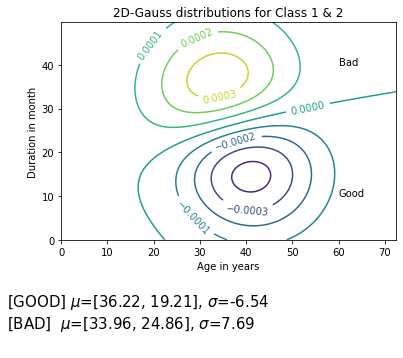

In [13]:
# identified top attributes
top_attr1 = COLS[Cols.AgeInYears]
top_attr2 = COLS[Cols.DurationInMonth]

df_ageXduration = pd.DataFrame({
    top_attr1 : df_normal[top_attr1],
    top_attr2 : df_normal[top_attr2],
    COLS[Cols.ClassOutcome] : df_normal[COLS[Cols.ClassOutcome]]
})

# run model again, but only for top attributes
acc_avg,mu_g,covma_g, mu_b, covma_b = gradient_descent(
    df=df_ageXduration, 
    iterations=500
)

mu_g = np.round(mu_g, 2)
mu_b = np.round(mu_b, 2)
covma_g = np.round(covma_g, 2)
covma_b = np.round(covma_b, 2)

print(f"<{top_attr1}> x <{top_attr2}>\nAvg Acc.={acc_avg}%\nmu[Good]={mu_g}, cov[Good]={covma_g}\nmu[Bad]={mu_b}, cov[Bad]={covma_b}")

# plot for top attribures
plot_sample(
    df=df_normal,
    top_attr=[
        top_attr1,
        top_attr2
    ],
    plot_scale=2
)

## Plot 2D Gaussian > numerical data

<u> x <h>
Avg Acc. = 69.97%, Max Acc. = 77.06%
Avg Risk = 72.83, Max Risk = 224.94

<u> x <h>
Avg Acc.=69.97%
mu[Good]=[0.77 2.82], cov[Good]=[[ 0.18 -0.13]
 [-0.13  1.23]]
mu[Bad]=[0.61 2.84], cov[Bad]=[[ 0.24 -0.23]
 [-0.23  1.19]]


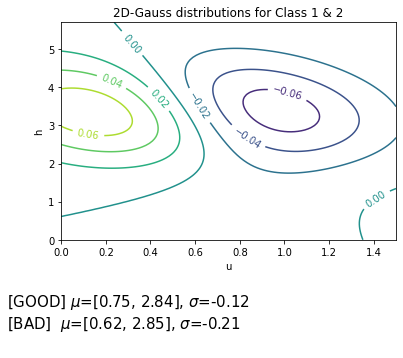

In [12]:
top_attr1 = 'u'
top_attr2 = 'h'

df_rXs = pd.DataFrame({
    top_attr1 : df_numerical[top_attr1],
    top_attr2 : df_numerical[top_attr2],
    COLS[Cols.ClassOutcome] : df_numerical[COLS[Cols.ClassOutcome]]
})

# run model again, but only for top attributes
acc_avg,mu_g,covma_g, mu_b, covma_b = gradient_descent(
    df=df_rXs, 
    iterations=500
)

mu_g = np.round(mu_g, 2)
mu_b = np.round(mu_b, 2)
covma_g = np.round(covma_g, 2)
covma_b = np.round(covma_b, 2)

print(f"<{top_attr1}> x <{top_attr2}>\nAvg Acc.={acc_avg}%\nmu[Good]={mu_g}, cov[Good]={covma_g}\nmu[Bad]={mu_b}, cov[Bad]={covma_b}")


plot_sample(
    df=df_numerical,
    top_attr=[
        top_attr1,
        top_attr2
    ],
    plot_scale=2
)

# Conclusion

## 1. Datasets
The task is to perform a binary classification task. For this purpose, the German dataset "german.data" is used, which contains 7 numeric and 13 qualitative attributes. In an additional dataset "german.data.numeric" all attributes are in numeric form. 

Classification analysis is performed for both datasets:
1. german.data (7 numerical attributes)
2. german.data-numeric (24 numerical attributes)

Each dataset is split to 67% training and 33% test.


## 2. Approach
### Calculate best 2 attributes
Since we are dealing with a binary classification problem, the function **routine_gradient_descent(df, columns, iterations)** is used to brute-force the 2-attribute combination that provides the highest average accuracy.
The function takes the following attributes:
- df: dataset to be examined
- columns: 2 attributes of the dataset to be examined
- iterations: number of iterations the Gradient Descent algorithm runs through to calculate a statistically relevant result for $\mu$ and $\Sigma$ (here iterations=500)

This function calls the gradient_descent(df, iterations) function.


### Calculate gaussian parameters for 2 attributes
The function **gradient_descent(df, iterations)** is used to train the model iteratively, i.e. the parameters $\mu$ and $\Sigma$ are determined based on two fixed attributes.
The function takes the following attributes:
- df: already known
- iterations: already known (here iterations=100)


## 3. Results: Normal data set
The used data set for the analysis is *german.data* which contains 7 numerical attributes.

### Accuracy
The highest accuracy (avg. acc ~ 65%) could be achieved with the numerical attributes
1. *Age in years*
2. *Duration in month*

### Risk Analysis
The risk analysis is abstracted by finding the average and maximum risk for each 2-combination of attributes.
For the combination *Age in years* & *Duration in month* the average risk is -9422.05. 
If you calculate the specific risk of an unknown value x (here: one row in the dataset), you should use the smallest of the three risk values: 
1. $R(x \text{ belongs to class 1})$
1. $R(x \text{ belongs to class 2})$
1. $R(\text{classification rejected})$

### Distribution (2-D Gaussian)
There is no intersection between the 2D Gaussian distributions for class=Good and class=Bad.
The following table shows the approximate 2D Gaussian parameters ($\mu$, $\Sigma$) for both classes (Good, Bad) and attributes *Age in years* and *Duration in month*.

|              | Class=Good        |                   | Class=Bad         |                   |
|--------------|-------------------|-------------------|-------------------|-------------------|
|              | Age in years      | Duration in month | Age in years      | Duration in month |
| **$\mu$**    | 36.53             | 19.30             | 32.91             | 24.69             |
| **$\Sigma$** | $\sigma$11=141.55 | $\sigma$12=-5.69  | $\sigma$11=110.91 | $\sigma$12=6.26   |
|              | $\sigma$21=-5.69  | $\sigma$22=127.28 | $\sigma$21=6.26   | $\sigma$22=181.14 |


## 4. Results: Numerical data set
The used data set for the analysis is *german.data* which contains 24 numerical attributes. The attributes are named alphabetically (a to x) because no headings are provided in the dataset or documentation.

### Accuracy
The highest accuracy (avg. acc ~70%) could be achieved with the numerical attributes:
1. *u*
2. *h*

### Risk Analysis
The risk analysis is abstracted by finding the average and maximum risk for each 2-combination of attributes.
For the combination *u* & *h* the average risk is -11.3. 

### Distribution (2-D Gaussian)
There is no intersection between the 2D Gaussian distributions for class=Good and class=Bad.
The following table shows the approximate 2D Gaussian parameters ($\mu$, $\Sigma$) for both classes (Good, Bad) and attributes *u* and *h*.

|          | Class=Good       | Class=Good        | Class=Bad        | Class=Bad         |
|----------|------------------|-------------------|------------------|-------------------|
|          | Age in years     | Duration in month | Age in years     | Duration in month |
| $\mu$    | 0.77             | 2.82              | 0.18             | 2.84              |
| $\Sigma$ | $\sigma$11=0.18  | $\sigma$12=-0.13  | $\sigma$11=0.24  | $\sigma$12=-0.23  |
|          | $\sigma$21=-0.13 | $\sigma$22=1.23   | $\sigma$21=-0.23 | $\sigma$22=1.19   |


# Author

Joel Amarou Heuer, 31. March